# 흉부 X-ray 영상을 통해 COVID-19 / 바이러스성 페렴 / 정상 분류

데이터셋: [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('파이토치 버전: ', torch.__version__)

Using PyTorch version 1.12.1+cu113


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/ColabNotebooks/Project

/content/gdrive/MyDrive/ColabNotebooks/Project


# Preparing Training and Test Sets

In [ ]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
  def __init__(self, image_dirs, transform):
    def get_images(class_name):
      images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
      print(f'Found {len(images)} {class_name} examples')
      return images

    self.images = {}
    self.class_names = ['normal', 'viral', 'covid']

    for c in self.class_names:
      self.images[c] = get_images(c)

    self.image_dirs = image_dirs
    self.transform = transform

  def __len__(self):
    return sum([len(self.images[c]) for c in self.class_names])

  def __getitem__(self, index):
    class_name = random.choice(self.class_names)
    index = index % len(self.images[class_name])
    image_name = self.images[class_name][index]
    image_path = os.path.join(self.image_dirs[class_name], image_name)
    image = Image.open(image_path).convert('RGB')
    return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [ ]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [ ]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [ ]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 470
Num of test batches 15


# Data Visualization

In [ ]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

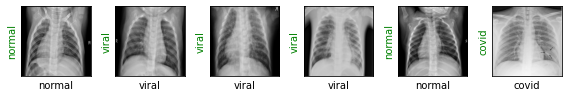

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

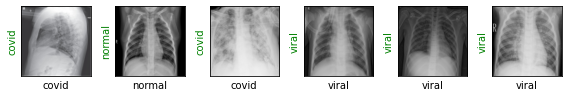

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

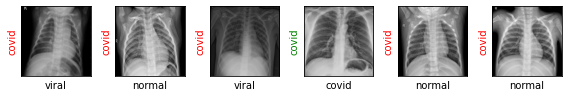

In [ ]:
show_preds()

# Training the Model

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*2)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*2)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 2 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                resnet18.train()

                # accurancy/ loss 조건을 더 명확하게 할것
                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [ ]:
%%time

train(epochs=1)

Starting training..
==
Starting epoch 1/1
==
Evaluating at step 0
Validation Loss: 1.5049, Accuracy: 0.3444
Evaluating at step 2
Validation Loss: 1.5821, Accuracy: 0.3222
Evaluating at step 4
Validation Loss: 1.1905, Accuracy: 0.5889
Evaluating at step 6
Validation Loss: 1.1027, Accuracy: 0.6667
Evaluating at step 8
Validation Loss: 1.1106, Accuracy: 0.6556
Evaluating at step 10
Validation Loss: 0.9606, Accuracy: 0.6111
Evaluating at step 12
Validation Loss: 0.8523, Accuracy: 0.7444
Evaluating at step 14
Validation Loss: 0.8252, Accuracy: 0.7333
Evaluating at step 16
Validation Loss: 0.9202, Accuracy: 0.6111
Evaluating at step 18
Validation Loss: 0.7634, Accuracy: 0.7556
Evaluating at step 20
Validation Loss: 0.8463, Accuracy: 0.6889
Evaluating at step 22
Validation Loss: 0.6979, Accuracy: 0.7222
Evaluating at step 24
Validation Loss: 0.5744, Accuracy: 0.8111
Evaluating at step 26
Validation Loss: 0.5449, Accuracy: 0.8333
Evaluating at step 28
Validation Loss: 0.5752, Accuracy: 0.8556


# Final Results

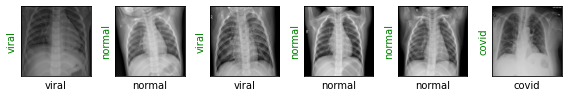

In [ ]:
show_preds()

In [1]:
# 학습 / 평가(test) 데이터 늘리기 => 2000장 / 500장
# COVID-19 비중 늘리기
# 추가 개선점: agmentation(이미지 mixing, 증폭) <- 논문 아이디어를 확인 후, 적용해보기(사용할 데이터셋이 너무 적기 때문에 해당 기법을 사용)
# test 시 정확한 지표를 나타낼 수 있어야 한다. (accurancy, %등)